This Google Colab is based off of the following Geek4Geeks article
* https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/

#Step 1: Importing Libraries

What is torch.optim?
* https://pytorch.org/docs/main/optim.html
* Implements various optimization algorithms like stochastic gradient descent and adam.

In [ ]:
import torch
import torch.nn as nn #torch.nn has alias nn now.
import torch.optim as optim #torch.optim has alias optim now.
import numpy as np #A library to deal with multi dimensional arrays
import matplotlib.pyplot as plt #A library to plot graphs

#Step 2: Creating Synthetic dataset
We will create a simple sine wave dataset. The goal is to predict the next value in the sine wave sequence.

What is linspace?
* Note that **linspace** will return evenly spaced numbers over a specified interval.
* np.linspace(start, stop, num):
* **start**: The starting value of the sequence.
* **stop**: The ending value of the sequence.
* **num**: The number of samples to generate (including both start and stop).

In [ ]:
#Generating sine wave data
def generate_data(seq_length, num_saples):
  X = []
  y = []
  for i in range(num_samples):
    #starting at value i*2*pi then end at value (i+1)*2*pi.  The total number of evenly spaced points generated will be seq_length + 1.
    x = np.linspace(i * 2 * np.pi, (i + 1) * 2 * np.pi, seq_length + 1) #This just generates evenly spaced numbers from i*2pi to (i+1)*2pi. Could be say, from 0 to 2pi. Then it is put into the sine wave function to get outputs.
    print("x vector contains:\n", x, "\n") #Shows us what the X vector contains.

    sine_wave = np.sin(x) #Obtain sin value when plugging in x
    print("sin(x) contains:\n", sine_wave, "\n") #Shows us what sine_wave contains
    X.append(sine_wave[:-1]) #input seq
    y.append(sine_wave[1:]) #target seq
  return np.array(X), np.array(y)

seq_length = 50 #Number of elements in the sequence of the data we want to generate for each sample. Words in a sentence can be sequence length.
num_samples = 1000 #The amount of samples we are creating, or the amount of data we are generating. For e.g. 4 sentences = 4 samples.
X, y = generate_data(seq_length, num_samples)

#Convert to PyTorch tensors
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

print(X.shape, y.shape)

Streaming output truncated to the last 5000 lines.
sin(x) contains:
 [-6.48728928e-13  1.25333234e-01  2.48689887e-01  3.68124553e-01
  4.81753674e-01  5.87785252e-01  6.84547106e-01  7.70513243e-01
  8.44327926e-01  9.04827052e-01  9.51056516e-01  9.82287251e-01
  9.98026728e-01  9.98026728e-01  9.82287251e-01  9.51056516e-01
  9.04827052e-01  8.44327926e-01  7.70513243e-01  6.84547106e-01
  5.87785252e-01  4.81753674e-01  3.68124553e-01  2.48689887e-01
  1.25333234e-01  3.18449021e-13 -1.25333234e-01 -2.48689887e-01
 -3.68124553e-01 -4.81753674e-01 -5.87785252e-01 -6.84547106e-01
 -7.70513243e-01 -8.44327926e-01 -9.04827052e-01 -9.51056516e-01
 -9.82287251e-01 -9.98026728e-01 -9.98026728e-01 -9.82287251e-01
 -9.51056516e-01 -9.04827052e-01 -8.44327926e-01 -7.70513243e-01
 -6.84547106e-01 -5.87785252e-01 -4.81753674e-01 -3.68124553e-01
 -2.48689887e-01 -1.25333234e-01  1.18308869e-14] 

x vector contains:
 [5164.7783225  5164.90398621 5165.02964991 5165.15531362 5165.28097733
 5165.40

#Step 3: Defining the RNN model

This RNN model contains two layers.

What does super(SimpleRNN, self).__init__() mean?
* The super() function is used to give access to methods and properties of a parent or sibling class.
* The super() function returns an object that represents the parent class.
* https://www.w3schools.com/python/ref_func_super.asp

Why is "batch_first=True"?
* https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

What are batches?
* https://medium.com/analytics-vidhya/when-and-why-are-batches-used-in-machine-learning-acda4eb00763
* Batches allow us to load our data in "batches" rather than all at once. Doing the later is more computationally expensive as opposed to doing it in batches.

What does nn.linear do?
* https://docs.kanaries.net/topics/Python/nn-linear
* In the context of neural networks, nn.Linear is a module provided by PyTorch that applies a linear transformation to the incoming data. This transformation is represented by the formula y = xA^T + b, where x is the input, A is the weight, b is the bias, and y is the output.

In [ ]:
class SimpleRNN(nn.Module): #https://medium.com/dejunhuang/learning-day-22-what-is-nn-module-in-pytorch-ecf8400f411a
  #Hidden size is the number of features in the hidden state.
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) #https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
      h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device) #Hidden State
      out, _ = self.rnn(x, h0)
      out = self.fc(out)
      return out

input_size = 1
hidden_size = 20
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

#Step 4: Training the Model

What is an epoch?
* https://www.geeksforgeeks.org/epoch-in-machine-learning/
* A complete pass through the entire training dataset during one cycle of model training

Overfitting can occur if num_epochs is too large.

Loss is our error.

In [ ]:
criterion = nn.MSELoss() #Mean Squared Error Loss function will be used. This is so we can find the difference between a model's predicted output against the target value.
optimizer = optim.Adam(model.parameters(), lr=0.001) #An optimization algorithm used to update the model's parameters.

# Training loop
#We can actually over fit this model if we have more epochs.
num_epochs = 100 #Epoch - "A complete pass through the entire training dataset during one cycle of model traning." https://www.geeksforgeeks.org/epoch-in-machine-learning/
for epoch in range(num_epochs):
    model.train() #tells model that we are training. https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    outputs = model(X.unsqueeze(2))  # Add a dimension for input size. Passes our data in X into the model and pushes it forward into its layers.
    loss = criterion(outputs, y.unsqueeze(2)) #here we calculatoe the loss in which we use MSELoss.

    #backpropogation
    #.zero_grad() is a method from the optimizer class.
    optimizer.zero_grad() #We want to set gradients to zero before doing backpropagation https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    loss.backward() #.backward() is built into PyTorch's Tensor class. Computes gradient of loss function (MSELoss()) w/respect to model's parameters.
    optimizer.step() #.step() is a method from torch.optim.SGD Updates the paramters.

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.3050
Epoch [20/100], Loss: 0.1864
Epoch [30/100], Loss: 0.0892
Epoch [40/100], Loss: 0.0729
Epoch [50/100], Loss: 0.0501
Epoch [60/100], Loss: 0.0390
Epoch [70/100], Loss: 0.0277
Epoch [80/100], Loss: 0.0181
Epoch [90/100], Loss: 0.0103
Epoch [100/100], Loss: 0.0054


#Step 5: See the Results

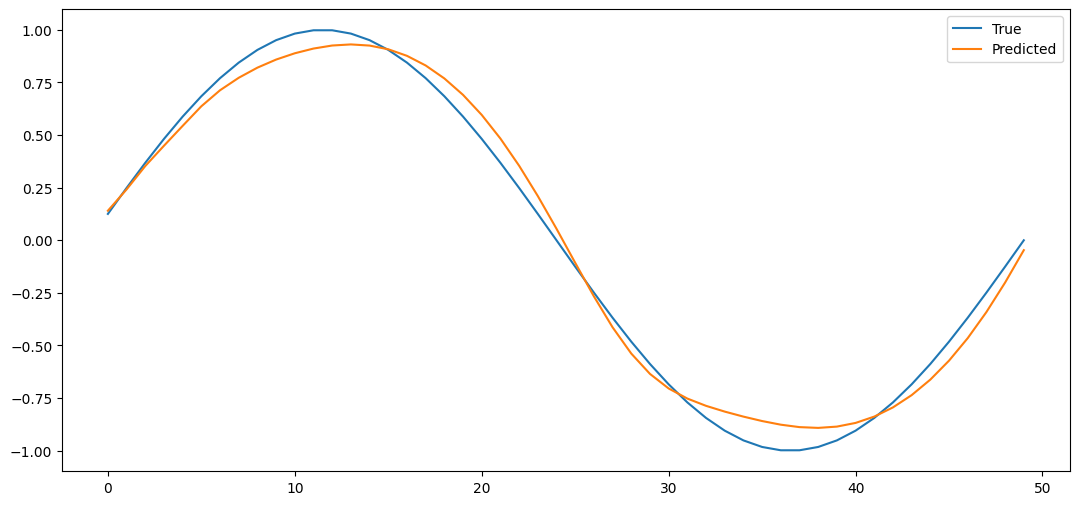

In [ ]:
# Make predictions
model.eval() #Tell our model that we are testing it now.

#we are turning off gradient calculation. https://pytorch.org/docs/stable/generated/torch.no_grad.html
#numpy can not be called on tensors that require grad.
with torch.no_grad(): #Explains what "with torch.no_grad()" is for: https://www.geeksforgeeks.org/what-is-with-torch-no_grad-in-pytorch/
    predictions = model(X.unsqueeze(2)).squeeze(2).numpy() #Explains what "unsqueeze" does. https://www.geeksforgeeks.org/what-does-unsqueeze-do-in-pytorch/#

# Plot results
plt.figure(figsize=(13, 6))
plt.plot(y[0].numpy(), label='True')
plt.plot(predictions[0], label='Predicted')
plt.legend()
plt.show()